<a href="https://colab.research.google.com/github/karaage0703/karaage-ai-book/blob/master/ch02/02_karaage_ai_book_image_classification_performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIモデルの性能を性能を上げる方法

## 教師データのダウンロード

ジャンケンの手の形の教師データをGitHubからダウンロード（Clone）します。

2,3行目はダウンロードしたデータから、使用するデータ以外の不要なファイルを削除しています。

In [1]:
!git clone https://github.com/karaage0703/janken_dataset datasets
!rm -rf /content/datasets/.git
!rm /content/datasets/LICENSE

Cloning into 'datasets'...
remote: Enumerating objects: 210, done.
remote: Total 210 (delta 0), reused 0 (delta 0), pack-reused 210
Receiving objects: 100% (210/210), 4.60 MiB | 11.48 MiB/s, done.
Resolving deltas: 100% (3/3), done.


## 教師データを訓練データ（Train Data）とテストデータ（Validation Data）に分ける

教師データのディレクトリと、ターゲットとなるディレクトリ（この下に訓練データのディレクトリと検証データのディレクトリが生成される）を指定します。

In [2]:
dataset_original_dir = 'datasets'
dataset_root_dir = 'target_datasets'

教師データを訓練データのディレクトリ(train)と検証データのディレクトリ（val）に分割するスクリプトをダウンロードします。

スクリプトのプログラムに関しては、本ノートブックの主題では無いので割愛します。興味ある方は以下のアドレスで、ソフトの中身を確認して下さい。

https://raw.githubusercontent.com/karaage0703/karaage-ai-book/master/util/split_train_val.py

In [3]:
!wget https://raw.githubusercontent.com/karaage0703/karaage-ai-book/master/util/split_train_val.py

--2021-03-20 03:39:39--  https://raw.githubusercontent.com/karaage0703/karaage-ai-book/master/util/split_train_val.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2683 (2.6K) [text/plain]
Saving to: ‘split_train_val.py’

split_train_val.py  100%[===================>]   2.62K  --.-KB/s    in 0s      

2021-03-20 03:39:39 (61.2 MB/s) - ‘split_train_val.py’ saved [2683/2683]



In [4]:
import split_train_val
split_train_val.image_dir_train_val_split(dataset_original_dir, dataset_root_dir, train_size=0.67)

datasets/pa copy is done
datasets/choki copy is done
datasets/gu copy is done
processing is done


In [5]:
train_dir = 'target_datasets/train'
val_dir = 'target_datasets/val'

## ラベルファイルの作成

学習するファイルのラベルを作成します

必要なライブラリをインポートします

In [6]:
import sys
import os
import shutil

データを保存する場所を指定します

In [7]:
backup_dir = './model'

ラベルデータを作成します（最後に表示される class numberが画像の種類の数です）

In [8]:
labels = [d for d in os.listdir(dataset_original_dir) \
    if os.path.isdir(os.path.join(dataset_original_dir, d))]
labels.sort()

if os.path.exists(backup_dir):
  shutil.rmtree(backup_dir)

os.makedirs(backup_dir)

with open(backup_dir + '/labels.txt','w') as f:
  for label in labels:
    f.write(label+"\n")

NUM_CLASSES = len(labels)
print("class number=" + str(NUM_CLASSES))

class number=3


ラベルを確認します。ラベル名（choki, gu, pa）が並んでいればOKです

In [9]:
!cat ./model/labels.txt

choki
gu
pa


## 学習の事前準備

### ライブラリのインポート

必要なライブラリをインポートします

In [10]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

2.4.1


続いて、他に必要なライブラリをインストールします。

In [11]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten

from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import time

先ほど作成したラベルファイルから、ラベル情報を読み込みます

In [12]:
labels = []
with open(backup_dir + '/labels.txt','r') as f:
    for line in f:
        labels.append(line.rstrip())
print(labels)

NUM_CLASSES = len(labels)

['choki', 'gu', 'pa']


### 学習のハイパーパラメータの設定

学習のハイパーパラメータの設定をします

In [13]:
# 学習率
LEARNING_RATE = 0.001
# エポック（世代数）
EPOCHS = 20
# バッチサイズ
BATCH_SIZE = 8

### データセットの前処理

データをTensorFlowで扱える形式に変換します

In [14]:
IMAGE_SIZE = 64

train_data_gen = ImageDataGenerator(rescale=1./255)
val_data_gen = ImageDataGenerator(rescale=1./255)

train_data = train_data_gen.flow_from_directory(
    train_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode='rgb', batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=True)

validation_data = val_data_gen.flow_from_directory(
    val_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode='rgb', batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=True)

Found 111 images belonging to 3 classes.
Found 56 images belonging to 3 classes.


## モデルの変更

In [15]:
model_2 = Sequential()

model_2.add(Conv2D(32, (3, 3), padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model_2.add(Activation('relu'))
model_2.add(Conv2D(32, (3, 3)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))

model_2.add(Conv2D(64, (3, 3), padding='same'))
model_2.add(Activation('relu'))
model_2.add(Conv2D(64, (3, 3)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(3, 3)))
model_2.add(Dropout(0.25))

model_2.add(Flatten())
model_2.add(Dense(512))
model_2.add(Activation('relu'))
model_2.add(Dropout(0.5))

model_2.add(Dense(NUM_CLASSES))
model_2.add(Activation('softmax'))

opt = tf.keras.optimizers.Adam(lr=LEARNING_RATE)
model_2.compile(opt, loss='categorical_crossentropy',
    metrics=['accuracy'])

In [16]:
model_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 64)        1

In [17]:
%%time
history = model_2.fit(train_data, epochs=EPOCHS, validation_data=validation_data, verbose=1)

Epoch 1/20
14/14 [==============================] - 31s 61ms/step - loss: 1.3215 - accuracy: 0.2928 - val_loss: 1.0985 - val_accuracy: 0.4107
Epoch 2/20
14/14 [==============================] - 0s 28ms/step - loss: 1.0968 - accuracy: 0.4333 - val_loss: 1.0936 - val_accuracy: 0.3929
Epoch 3/20
14/14 [==============================] - 0s 28ms/step - loss: 1.0937 - accuracy: 0.3415 - val_loss: 1.0904 - val_accuracy: 0.3929
Epoch 4/20
14/14 [==============================] - 0s 28ms/step - loss: 1.1356 - accuracy: 0.3877 - val_loss: 1.0952 - val_accuracy: 0.3929
Epoch 5/20
14/14 [==============================] - 0s 29ms/step - loss: 1.0910 - accuracy: 0.4572 - val_loss: 1.0884 - val_accuracy: 0.3929
Epoch 6/20
14/14 [==============================] - 0s 29ms/step - loss: 1.0878 - accuracy: 0.3694 - val_loss: 1.0680 - val_accuracy: 0.3929
Epoch 7/20
14/14 [==============================] - 0s 30ms/step - loss: 1.0505 - accuracy: 0.4473 - val_loss: 1.0305 - val_accuracy: 0.8571
Epoch 8/20
1

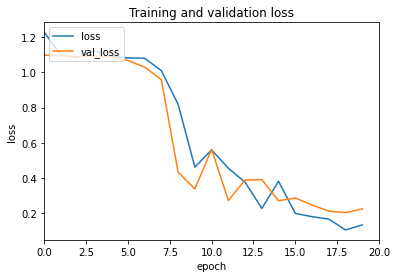

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlim([0.0, EPOCHS])
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

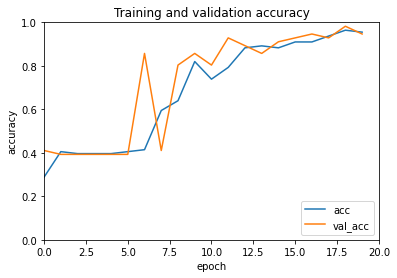

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.xlim([0.0, EPOCHS])
plt.ylim([0.0, 1.0])
plt.legend(['acc', 'val_acc'], loc='lower right')
plt.show()

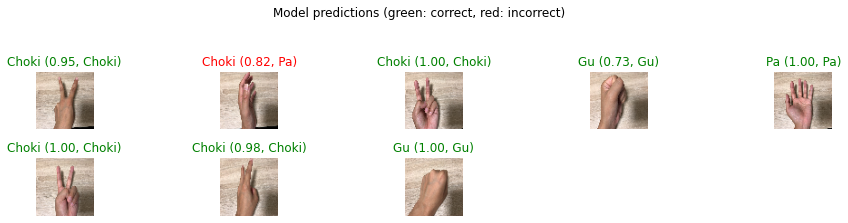

In [20]:
# Get the ordered list of class names:
import PIL.Image as Image
class_names = validation_data.class_indices.items()
class_names = np.array([key.title() for key, value in class_names])

validation_data.reset()
validation_data.shuffle = True
validation_data.batch_size = BATCH_SIZE

# Retrieve the first batch from the validation data
for validation_image_batch, validation_label_batch in validation_data:
  break

validation_id = np.argmax(validation_label_batch, axis=-1)
validation_label = class_names[validation_id]
predicted_batch = model_2.predict(validation_image_batch)

# Returns the indices of the maximum values along a given axis
predicted_id = np.argmax(predicted_batch, axis=-1)

# Return the maximum values along a given axis
predicted_score = np.max(predicted_batch, axis=-1)

predicted_label_batch = class_names[predicted_id]

plt.figure(figsize=(16, 9))
plt.subplots_adjust(hspace=0.5)

# Display the classification results for the first 30 images
for n in range(min(validation_image_batch.shape[0], 30)):
  plt.subplot(6, 5, n + 1)

  # Convert the range from -1 to 1 to the range from 0 to 1
  plt.imshow(np.array(validation_image_batch[n]*255,np.int32))
  color = 'green' if predicted_id[n] == validation_id[n] else 'red'
  predicted_label = predicted_label_batch[n].title()
  plt.title(predicted_label + ' ({:.2f}, {})'.format(
      predicted_score[n], validation_label[n]), color=color)
  plt.axis('off')

_ = plt.suptitle('Model predictions (green: correct, red: incorrect)')

## 転移学習

### MobileNetV2

MobileNet V2を読み込みます。

In [21]:
mobilenet_pretrained_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    include_top=False,
    weights= 'imagenet')

opt = tf.keras.optimizers.Adam(lr=LEARNING_RATE)

9412608/9406464 [==============================] - 0s 0us/step


In [22]:
mobilenet_pretrained_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 32, 32, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 32, 32, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 32, 32, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [23]:
(image_data, _) = train_data.next()
feature_batch = mobilenet_pretrained_model(image_data)
print(feature_batch.shape)

(8, 2, 2, 1280)


In [24]:
mobilenet_pretrained_model.trainable = False

In [25]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(8, 1280)


注意： 以下の行`prediction_layer`に活性化層として`softmax`を指定していなかったため書籍では性能が正しく出ていませんでした。指定することで`mobilenet`でも高い性能が出ます。

参考： https://github.com/karaage0703/karaage-ai-book/issues/26

In [26]:
prediction_layer = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(8, 3)


In [27]:
mobilenet_train_model = tf.keras.Sequential([
  mobilenet_pretrained_model,
  global_average_layer,
  prediction_layer
])

In [28]:
mobilenet_train_model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
mobilenet_train_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 2, 2, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


学習します。

In [30]:
%%time
history = mobilenet_train_model.fit(train_data, epochs=EPOCHS, validation_data=validation_data, verbose=1)

Epoch 1/20
14/14 [==============================] - 3s 88ms/step - loss: 1.0846 - accuracy: 0.5877 - val_loss: 0.4483 - val_accuracy: 0.8571
Epoch 2/20
14/14 [==============================] - 0s 32ms/step - loss: 0.2897 - accuracy: 0.8967 - val_loss: 0.2022 - val_accuracy: 0.9643
Epoch 3/20
14/14 [==============================] - 0s 31ms/step - loss: 0.1191 - accuracy: 0.9877 - val_loss: 0.1518 - val_accuracy: 0.9643
Epoch 4/20
14/14 [==============================] - 0s 32ms/step - loss: 0.0640 - accuracy: 0.9949 - val_loss: 0.1392 - val_accuracy: 0.9643
Epoch 5/20
14/14 [==============================] - 0s 32ms/step - loss: 0.0429 - accuracy: 1.0000 - val_loss: 0.1307 - val_accuracy: 0.9643
Epoch 6/20
14/14 [==============================] - 0s 32ms/step - loss: 0.0369 - accuracy: 1.0000 - val_loss: 0.1200 - val_accuracy: 0.9643
Epoch 7/20
14/14 [==============================] - 0s 32ms/step - loss: 0.0373 - accuracy: 1.0000 - val_loss: 0.1144 - val_accuracy: 0.9643
Epoch 8/20
14

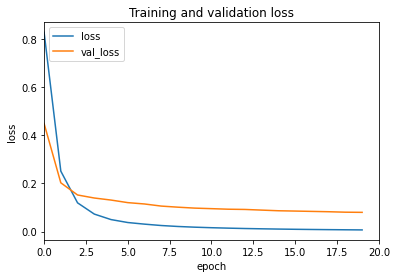

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlim([0.0, EPOCHS])
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

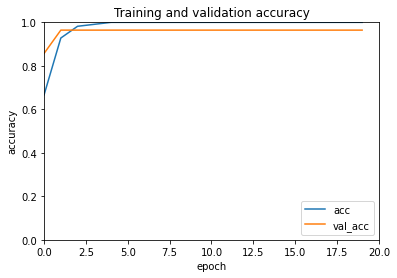

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.xlim([0.0, EPOCHS])
plt.ylim([0.0, 1.0])
plt.legend(['acc', 'val_acc'], loc='lower right')
plt.show()

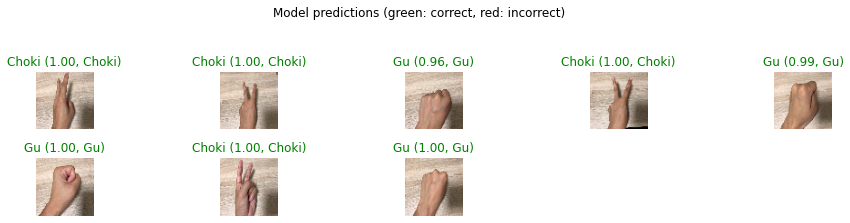

In [33]:
# Get the ordered list of class names:
import PIL.Image as Image
class_names = validation_data.class_indices.items()
class_names = np.array([key.title() for key, value in class_names])

validation_data.reset()
validation_data.shuffle = True
validation_data.batch_size = BATCH_SIZE

# Retrieve the first batch from the validation data
for validation_image_batch, validation_label_batch in validation_data:
  break

validation_id = np.argmax(validation_label_batch, axis=-1)
validation_label = class_names[validation_id]
predicted_batch = mobilenet_train_model.predict(validation_image_batch)

# Returns the indices of the maximum values along a given axis
predicted_id = np.argmax(predicted_batch, axis=-1)

# Return the maximum values along a given axis
predicted_score = np.max(predicted_batch, axis=-1)

predicted_label_batch = class_names[predicted_id]

plt.figure(figsize=(16, 9))
plt.subplots_adjust(hspace=0.5)

# Display the classification results for the first 30 images
for n in range(min(validation_image_batch.shape[0], 30)):
  plt.subplot(6, 5, n + 1)

  # Convert the range from -1 to 1 to the range from 0 to 1
  plt.imshow(np.array(validation_image_batch[n]*255,np.int32))
  color = 'green' if predicted_id[n] == validation_id[n] else 'red'
  predicted_label = predicted_label_batch[n].title()
  plt.title(predicted_label + ' ({:.2f}, {})'.format(
      predicted_score[n], validation_label[n]), color=color)
  plt.axis('off')

_ = plt.suptitle('Model predictions (green: correct, red: incorrect)')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


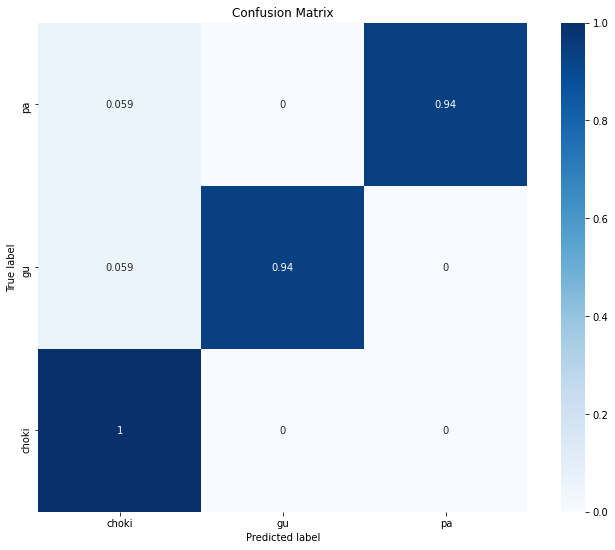

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

validation_data.reset()
validation_data.shuffle =  False
validation_data.batch_size = 1

# Retrieve the first batch from the validation data
for validation_image_batch, validation_label_batch in validation_data:
  break

predicted = mobilenet_train_model.predict_generator(validation_data, steps=validation_data.n)
predicted_classes = np.argmax(predicted, axis=-1)

# Apply normalization
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
cm = confusion_matrix(validation_data.classes, predicted_classes)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 9))

# https://seaborn.pydata.org/generated/seaborn.heatmap.html
# https://matplotlib.org/users/colormaps.html
sns.heatmap(cm, annot=True, square=True, cmap=plt.cm.Blues,
            xticklabels=validation_data.class_indices,
            yticklabels=validation_data.class_indices)

plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xlim([0.0, 3.0])
plt.ylim([0.0, 3.0])
plt.show()

### EfficientNet

In [35]:
import tensorflow_hub as hub

In [36]:
feature_extractor_url = "https://tfhub.dev/google/efficientnet/b0/feature-vector/1" #@param {type:"string"}

In [37]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

In [38]:
feature_extractor_layer.trainable = False

In [39]:
efficientnet_model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [40]:
efficientnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              4049564   
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 3843      
Total params: 4,053,407
Trainable params: 3,843
Non-trainable params: 4,049,564
_________________________________________________________________


In [41]:
efficientnet_model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [42]:
%%time
history = efficientnet_model.fit(train_data, epochs=EPOCHS, validation_data=validation_data, verbose=1)

Epoch 1/20
14/14 [==============================] - 4s 120ms/step - loss: 0.9284 - accuracy: 0.5712 - val_loss: 0.2760 - val_accuracy: 0.9464
Epoch 2/20
14/14 [==============================] - 1s 66ms/step - loss: 0.1665 - accuracy: 1.0000 - val_loss: 0.1265 - val_accuracy: 0.9821
Epoch 3/20
14/14 [==============================] - 1s 64ms/step - loss: 0.0560 - accuracy: 1.0000 - val_loss: 0.0922 - val_accuracy: 0.9821
Epoch 4/20
14/14 [==============================] - 1s 65ms/step - loss: 0.0414 - accuracy: 1.0000 - val_loss: 0.0822 - val_accuracy: 0.9821
Epoch 5/20
14/14 [==============================] - 1s 63ms/step - loss: 0.0335 - accuracy: 1.0000 - val_loss: 0.0757 - val_accuracy: 0.9821
Epoch 6/20
14/14 [==============================] - 1s 65ms/step - loss: 0.0239 - accuracy: 1.0000 - val_loss: 0.0698 - val_accuracy: 0.9821
Epoch 7/20
14/14 [==============================] - 1s 63ms/step - loss: 0.0230 - accuracy: 1.0000 - val_loss: 0.0663 - val_accuracy: 0.9821
Epoch 8/20
1

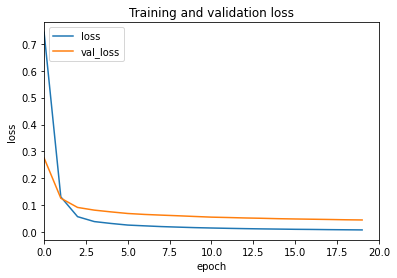

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlim([0.0, EPOCHS])
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

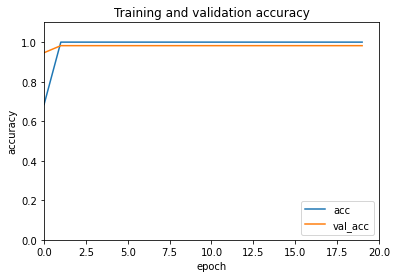

In [44]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.xlim([0.0, EPOCHS])
plt.ylim([0.0, 1.1])
plt.legend(['acc', 'val_acc'], loc='lower right')
plt.show()

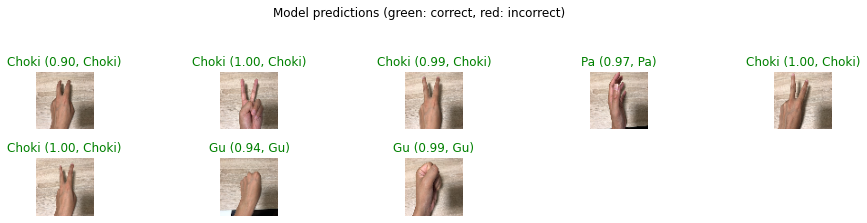

In [45]:
# Get the ordered list of class names:
import PIL.Image as Image
class_names = validation_data.class_indices.items()
class_names = np.array([key.title() for key, value in class_names])

validation_data.reset()
validation_data.shuffle = True
validation_data.batch_size = BATCH_SIZE

# Retrieve the first batch from the validation data
for validation_image_batch, validation_label_batch in validation_data:
  break

validation_id = np.argmax(validation_label_batch, axis=-1)
validation_label = class_names[validation_id]
predicted_batch = efficientnet_model.predict(validation_image_batch)

# Returns the indices of the maximum values along a given axis
predicted_id = np.argmax(predicted_batch, axis=-1)

# Return the maximum values along a given axis
predicted_score = np.max(predicted_batch, axis=-1)

predicted_label_batch = class_names[predicted_id]

plt.figure(figsize=(16, 9))
plt.subplots_adjust(hspace=0.5)

# Display the classification results for the first 30 images
for n in range(min(validation_image_batch.shape[0], 30)):
  plt.subplot(6, 5, n + 1)

  # Convert the range from -1 to 1 to the range from 0 to 1
  plt.imshow(np.array(validation_image_batch[n]*255,np.int32))
  color = 'green' if predicted_id[n] == validation_id[n] else 'red'
  predicted_label = predicted_label_batch[n].title()
  plt.title(predicted_label + ' ({:.2f}, {})'.format(
      predicted_score[n], validation_label[n]), color=color)
  plt.axis('off')

_ = plt.suptitle('Model predictions (green: correct, red: incorrect)')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


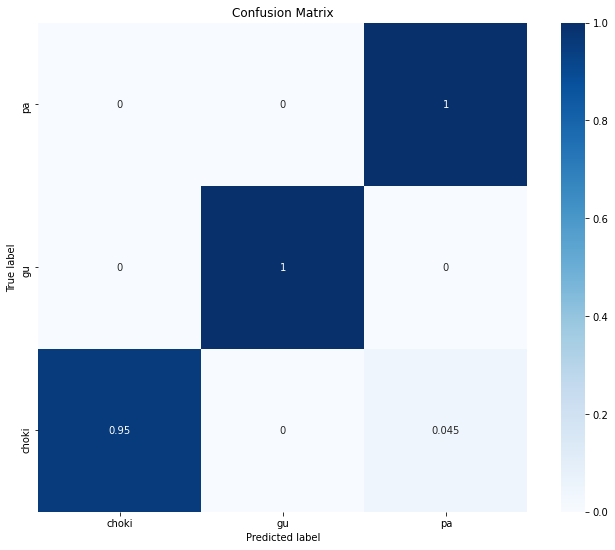

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

validation_data.reset()
validation_data.shuffle =  False
validation_data.batch_size = 1

# Retrieve the first batch from the validation data
for validation_image_batch, validation_label_batch in validation_data:
  break

predicted = efficientnet_model.predict_generator(validation_data, steps=validation_data.n)
predicted_classes = np.argmax(predicted, axis=-1)

# Apply normalization
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
cm = confusion_matrix(validation_data.classes, predicted_classes)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 9))

# https://seaborn.pydata.org/generated/seaborn.heatmap.html
# https://matplotlib.org/users/colormaps.html
sns.heatmap(cm, annot=True, square=True, cmap=plt.cm.Blues,
            xticklabels=validation_data.class_indices,
            yticklabels=validation_data.class_indices)

plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xlim([0.0, 3.0])
plt.ylim([0.0, 3.0])
plt.show()

## データ水増し

データをデータ水増し用のディレクトリにコピー

In [ ]:
!cp -r ./target_datasets/train ./target_datasets/train_aug
!cp ./datasets/choki/choki_01.jpg ./target_datasets/train_aug/choki

データ水増し用のディレクトリを定義

In [ ]:
train_aug_dir = 'target_datasets/train_aug'

必要なライブラリをインポート

In [ ]:
import cv2
import numpy as np
import sys
import os
import glob

In [ ]:
# ヒストグラム均一化
def equalizeHistRGB(src):
    RGB = cv2.split(src)
    Blue   = RGB[0]
    Green = RGB[1]
    Red    = RGB[2]
    for i in range(3):
        cv2.equalizeHist(RGB[i])

    img_hist = cv2.merge([RGB[0],RGB[1], RGB[2]])
    return img_hist

# ガウシアンノイズ
def addGaussianNoise(src):
    row,col,ch= src.shape
    mean = 0
    var = 0.1
    sigma = 15
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = src + gauss

    return noisy

# salt&pepperノイズ
def addSaltPepperNoise(src):
    row,col,ch = src.shape
    s_vs_p = 0.5
    amount = 0.004
    out = src.copy()
    # Salt mode
    num_salt = np.ceil(amount * src.size * s_vs_p)
    coords = [np.random.randint(0, i-1 , int(num_salt))
                 for i in src.shape]
    out[coords[:-1]] = (255,255,255)

    # Pepper mode
    num_pepper = np.ceil(amount* src.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i-1 , int(num_pepper))
             for i in src.shape]
    out[coords[:-1]] = (0,0,0)

    return out

In [ ]:
labels = os.listdir(dataset_original_dir)

image_file_names = []

for label in labels:
  image_files = glob.glob(train_aug_dir + '/' + label +'/*')
  for image_file in image_files:
    image_file_names.append(image_file)

print(image_file_names)

['target_datasets/train_aug/pa/IMG_0856.JPG', 'target_datasets/train_aug/pa/IMG_0838.JPG', 'target_datasets/train_aug/pa/IMG_0850.JPG', 'target_datasets/train_aug/pa/IMG_0837.JPG', 'target_datasets/train_aug/pa/IMG_0866.JPG', 'target_datasets/train_aug/pa/IMG_0832.JPG', 'target_datasets/train_aug/pa/IMG_0865.JPG', 'target_datasets/train_aug/pa/IMG_0857.JPG', 'target_datasets/train_aug/pa/IMG_0821.JPG', 'target_datasets/train_aug/pa/IMG_0834.JPG', 'target_datasets/train_aug/pa/IMG_0847.JPG', 'target_datasets/train_aug/pa/IMG_0826.JPG', 'target_datasets/train_aug/pa/IMG_0841.JPG', 'target_datasets/train_aug/pa/IMG_0835.JPG', 'target_datasets/train_aug/pa/IMG_0827.JPG', 'target_datasets/train_aug/pa/IMG_0849.JPG', 'target_datasets/train_aug/pa/IMG_0824.JPG', 'target_datasets/train_aug/pa/IMG_0831.JPG', 'target_datasets/train_aug/pa/IMG_0822.JPG', 'target_datasets/train_aug/pa/IMG_0830.JPG', 'target_datasets/train_aug/pa/IMG_0851.JPG', 'target_datasets/train_aug/pa/IMG_0840.JPG', 'target_d

In [ ]:
# ルックアップテーブルの生成
min_table = 50
max_table = 205
diff_table = max_table - min_table
gamma1 = 0.75
gamma2 = 1.5

LUT_HC = np.arange(256, dtype = 'uint8')
LUT_LC = np.arange(256, dtype = 'uint8')
LUT_G1 = np.arange(256, dtype = 'uint8')
LUT_G2 = np.arange(256, dtype = 'uint8')

LUTs = []

# 平滑化用
average_square = (10,10)

# ハイコントラストLUT作成
for i in range(0, min_table):
  LUT_HC[i] = 0

for i in range(min_table, max_table):
  LUT_HC[i] = 255 * (i - min_table) / diff_table

for i in range(max_table, 255):
  LUT_HC[i] = 255

# その他LUT作成
for i in range(256):
  LUT_LC[i] = min_table + i * (diff_table) / 255
  LUT_G1[i] = 255 * pow(float(i) / 255, 1.0 / gamma1)
  LUT_G2[i] = 255 * pow(float(i) / 255, 1.0 / gamma2)

LUTs.append(LUT_HC)
LUTs.append(LUT_LC)
LUTs.append(LUT_G1)
LUTs.append(LUT_G2)


for image_file in image_file_names:
#  print(image_file)
  # 画像の読み込み
  img_src = cv2.imread(image_file, 1)
  trans_img = []
  trans_img.append(img_src)

  # LUT変換
  for i, LUT in enumerate(LUTs):
    trans_img.append(cv2.LUT(img_src, LUT))

	# 平滑化
  trans_img.append(cv2.blur(img_src, average_square))

	# ヒストグラム均一化
  trans_img.append(equalizeHistRGB(img_src))

	# ノイズ付加
  trans_img.append(addGaussianNoise(img_src))
  trans_img.append(addSaltPepperNoise(img_src))

	# 反転
  flip_img = []
  for img in trans_img:
     flip_img.append(cv2.flip(img, 1))
  trans_img.extend(flip_img)

  dir_name =  os.path.splitext(os.path.dirname(image_file))[0]
  base_name =  os.path.splitext(os.path.basename(image_file))[0]
  img_src.astype(np.float64)
  
  for i, img in enumerate(trans_img):
    if i > 0:
      cv2.imwrite(dir_name + '/trans_' + base_name + '_' + str(i-1) + '.jpg' ,img)

NameError: ignored

ディレクトリの中身を確認します。

In [ ]:
!ls target_datasets/train_aug/choki

choki_01.jpg	       trans_IMG_0789_9.jpg   trans_IMG_0813_1.jpg
IMG_0771.JPG	       trans_IMG_0791_0.jpg   trans_IMG_0813_2.jpg
IMG_0772.JPG	       trans_IMG_0791_10.jpg  trans_IMG_0813_3.jpg
IMG_0773.JPG	       trans_IMG_0791_11.jpg  trans_IMG_0813_4.jpg
IMG_0774.JPG	       trans_IMG_0791_12.jpg  trans_IMG_0813_5.jpg
IMG_0777.JPG	       trans_IMG_0791_13.jpg  trans_IMG_0813_6.jpg
IMG_0778.JPG	       trans_IMG_0791_14.jpg  trans_IMG_0813_7.jpg
IMG_0779.JPG	       trans_IMG_0791_15.jpg  trans_IMG_0813_8.jpg
IMG_0782.JPG	       trans_IMG_0791_16.jpg  trans_IMG_0813_9.jpg
IMG_0785.JPG	       trans_IMG_0791_1.jpg   trans_IMG_0814_0.jpg
IMG_0786.JPG	       trans_IMG_0791_2.jpg   trans_IMG_0814_10.jpg
IMG_0787.JPG	       trans_IMG_0791_3.jpg   trans_IMG_0814_11.jpg
IMG_0789.JPG	       trans_IMG_0791_4.jpg   trans_IMG_0814_12.jpg
IMG_0791.JPG	       trans_IMG_0791_5.jpg   trans_IMG_0814_13.jpg
IMG_0792.JPG	       trans_IMG_0791_6.jpg   trans_IMG_0814_14.jpg
IMG_0793.JPG	       trans_IMG_0791_

水増しされたファイル(`trans_xxx.jpg`) というファイルが大量にあればOKです。

水増しされたデータを確認してみましょう。

代表例として、冒頭確認したチョキの画像の水増しされた画像を結合して、1枚の写真にして表示します。

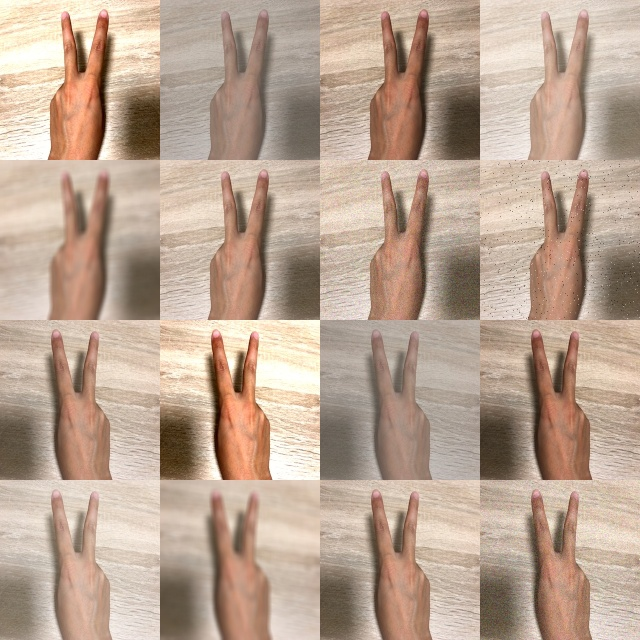

In [ ]:
tmp_file_name = './target_datasets/train_aug/choki/trans_choki_01'

tmp_image = []
for i in range(16):
      tmp_image.append(cv2.imread(tmp_file_name + '_' + str(i) + '.jpg'))

tmp_hconcat_image = []
tmp_hconcat_image.append(cv2.hconcat(tmp_image[0:4]))
tmp_hconcat_image.append(cv2.hconcat(tmp_image[4:8]))
tmp_hconcat_image.append(cv2.hconcat(tmp_image[8:12]))
tmp_hconcat_image.append(cv2.hconcat(tmp_image[12:16]))

concat_image = cv2.vconcat(tmp_hconcat_image[0:4])
concat_image = cv2.resize(concat_image, dsize=(640, 640))
cv2.imwrite('concat.jpg', concat_image)

from IPython.display import Image as IPImage
from IPython.display import display_jpeg
display_jpeg(IPImage('concat.jpg'))

### 学習の事前準備

In [ ]:
train_aug_data = train_data_gen.flow_from_directory(
    train_aug_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode='rgb', batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=True)

Found 1998 images belonging to 3 classes.


モデル作成に必要なライブラリのインポート

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
#from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import time

MNISTベースのモデルを作成

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES))
model.add(Activation('softmax'))

opt = tf.keras.optimizers.Adam(lr=LEARNING_RATE)
#opt = tf.keras.optimizers.SGD(lr=LEARNING_RATE)

model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])

## AIモデルの学習
AIモデルの学習を行います

In [ ]:
%%time
history = model.fit(train_aug_data, epochs=EPOCHS, validation_data=validation_data, verbose=1)

Epoch 1/20
250/250 [==============================] - 5s 19ms/step - loss: 0.4847 - accuracy: 0.8068 - val_loss: 0.3702 - val_accuracy: 0.8750
Epoch 2/20
250/250 [==============================] - 5s 18ms/step - loss: 0.0260 - accuracy: 0.9945 - val_loss: 0.4642 - val_accuracy: 0.8214
Epoch 3/20
250/250 [==============================] - 5s 18ms/step - loss: 0.0284 - accuracy: 0.9920 - val_loss: 0.7352 - val_accuracy: 0.8750
Epoch 4/20
250/250 [==============================] - 5s 19ms/step - loss: 0.0246 - accuracy: 0.9940 - val_loss: 0.4347 - val_accuracy: 0.8750
Epoch 5/20
250/250 [==============================] - 5s 19ms/step - loss: 0.0083 - accuracy: 0.9985 - val_loss: 0.4666 - val_accuracy: 0.8929
Epoch 6/20
250/250 [==============================] - 5s 19ms/step - loss: 0.0243 - accuracy: 0.9930 - val_loss: 0.3581 - val_accuracy: 0.9464
Epoch 7/20
250/250 [==============================] - 5s 19ms/step - loss: 0.0095 - accuracy: 0.9955 - val_loss: 0.5484 - val_accuracy: 0.8929

## 学習結果の可視化

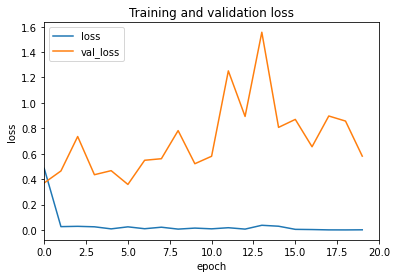

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlim([0.0, EPOCHS])
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

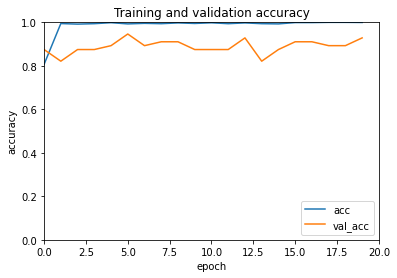

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.xlim([0.0, EPOCHS])
plt.ylim([0.0, 1.0])
plt.legend(['acc', 'val_acc'], loc='lower right')
plt.show()

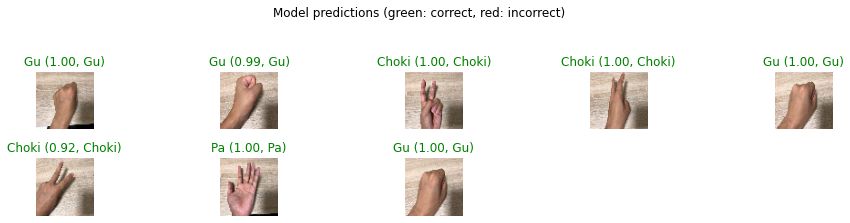

In [ ]:
# Get the ordered list of class names:
import PIL.Image as Image
class_names = validation_data.class_indices.items()
class_names = np.array([key.title() for key, value in class_names])

validation_data.reset()
validation_data.shuffle = True
validation_data.batch_size = BATCH_SIZE

# Retrieve the first batch from the validation data
for validation_image_batch, validation_label_batch in validation_data:
  break

validation_id = np.argmax(validation_label_batch, axis=-1)
validation_label = class_names[validation_id]
predicted_batch = model.predict(validation_image_batch)

# Returns the indices of the maximum values along a given axis
predicted_id = np.argmax(predicted_batch, axis=-1)

# Return the maximum values along a given axis
predicted_score = np.max(predicted_batch, axis=-1)

predicted_label_batch = class_names[predicted_id]

plt.figure(figsize=(16, 9))
plt.subplots_adjust(hspace=0.5)

# Display the classification results for the first 30 images
for n in range(min(validation_image_batch.shape[0], 30)):
  plt.subplot(6, 5, n + 1)

  # Convert the range from -1 to 1 to the range from 0 to 1
  plt.imshow(np.array(validation_image_batch[n]*255,np.int32))
  color = 'green' if predicted_id[n] == validation_id[n] else 'red'
  predicted_label = predicted_label_batch[n].title()
  plt.title(predicted_label + ' ({:.2f}, {})'.format(
      predicted_score[n], validation_label[n]), color=color)
  plt.axis('off')

_ = plt.suptitle('Model predictions (green: correct, red: incorrect)')

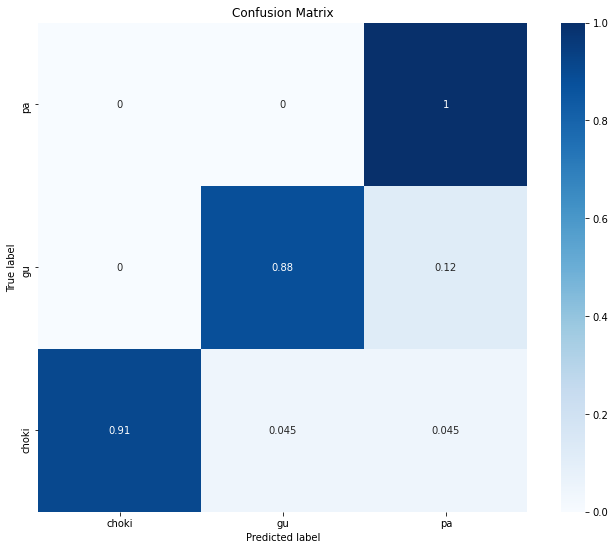

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

validation_data.reset()
validation_data.shuffle =  False
validation_data.batch_size = 1

# Retrieve the first batch from the validation data
for validation_image_batch, validation_label_batch in validation_data:
  break

predicted = model.predict_generator(validation_data, steps=validation_data.n)
predicted_classes = np.argmax(predicted, axis=-1)

# Apply normalization
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
cm = confusion_matrix(validation_data.classes, predicted_classes)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 9))

# https://seaborn.pydata.org/generated/seaborn.heatmap.html
# https://matplotlib.org/users/colormaps.html
sns.heatmap(cm, annot=True, square=True, cmap=plt.cm.Blues,
            xticklabels=validation_data.class_indices,
            yticklabels=validation_data.class_indices)

plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xlim([0.0, 3.0])
plt.ylim([0.0, 3.0])
plt.show()

## モデル保存

In [ ]:
save_model_path = os.path.join(backup_dir, 'efficientnet_model.h5')
efficientnet_model.save(save_model_path)

In [ ]:
save_model_path = os.path.join(backup_dir, 'my_model_aug.h5')
model.save(save_model_path)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp './model/efficientnet_model.h5' '/content/drive/My Drive'
!cp './model/my_model_aug.h5' '/content/drive/My Drive'
!cp './model/labels.txt' '/content/drive/My Drive'

# 参考リンク

- https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb
- http://ni4muraano.hatenablog.com/entry/2019/06/16/084011
- https://qiita.com/wakame1367/items/d90fa56bd9d11c4db50e